# Анализ лояльности пользователей Яндекс Афиши

Автор: Кулинич Ксения Леонидовна

Дата: 25.10.2025

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:


Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
!pip install phik
!pip install dotenv
!pip install pandas

In [2]:
from dotenv import load_dotenv
import os

load_dotenv()

DB_HOST=os.getenv("DB_HOST")
DB_NAME=os.getenv("DB_NAME")
DB_PORT=os.getenv("DB_PORT")
DB_USER=os.getenv("DB_USER")
DB_PASSWORD=os.getenv("DB_PASSWORD")

In [3]:
#импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import phik
from phik.report import plot_correlation_matrix

# Параметры подключения 
DB_CONFIG = {
    'host': DB_HOST,
    'port': DB_PORT,
    'database': DB_NAME,
    'user': DB_USER,
    'password': DB_PASSWORD
}

# код подключения 
engine = create_engine(f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}")

# SQL-запрос 
query = """
WITH set_config_precode AS (
    SELECT set_config('synchronize_seqscans', 'off', true)
)
SELECT 
    p.user_id, 
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue, 
    p.tickets_count,
    EXTRACT('days' FROM p.created_dt_msk - LAG(p.created_dt_msk) OVER(PARTITION BY user_id ORDER BY p.created_dt_msk)) AS days_since_prev,
    p.event_id, 
    e.event_name_code AS event_name,
    e.event_type_main, 
    p.service_name,
    r.region_name, 
    c.city_name 
FROM afisha.purchases AS p 
INNER JOIN afisha.events AS e ON p.event_id = e.event_id 
LEFT JOIN afisha.city AS c ON e.city_id = c.city_id 
LEFT JOIN afisha.regions AS r ON c.region_id = r.region_id
WHERE device_type_canonical IN ('mobile', 'desktop')
  AND e.event_type_main != 'фильм'
ORDER BY user_id
"""

# загрузка данных в датафрейм
df = pd.read_sql(query, engine)


df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [4]:
# Размер таблицы
print('Размер таблицы:', df.shape)

# Общая информация о типах данных
print('\nИнформация о типах данных:')
print(df.info())


Размер таблицы: (290611, 15)

Информация о типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object 


Вывод:
- Данных выгружено 290611 строк и 16 столбцов.
- Пропуски есть только в столбце `days_since_prev`.
- Типы данных в основном корректные,  категориальные данные переведем в тип `category`.
- Уменьшим разрядность в тех данных где это возможно.
- Данные выглядят корректно, ошибок в выгрузке не обнаружено.

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [5]:
# Загружаем таблицу курсов тенге 
url = 'https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv'
tenge_rates = pd.read_csv(url)

display(tenge_rates.head())

# Добавляем столбец revenue_rub с приведением выручки к рублям с рассчетом среднего курса (рублей за 100 тенге)
df['revenue_rub'] = np.where(
    df['currency_code'] == 'KZT',
    df['revenue'] * tenge_rates['curs'].mean() / 100,
    df['revenue']
)

#проверим что рублевые значения выглядят разумно
df.groupby('currency_code')['revenue_rub'].mean()


,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


currency_code
kzt    4995.206767
rub     548.013929
Name: revenue_rub, dtype: float64

Результаты преобразования выручки в тенге к рублям сохранили в новый столбец revenue_rub.

---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [6]:
# Проверим пропуски
print('\nКоличество пропусков в каждом столбце:')
print(df.isna().sum())



Количество пропусков в каждом столбце:
user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
revenue_rub                  0
dtype: int64


In [7]:
# понизим разрядность целочисленных и вещественных (для экономии памяти)
for col in ['order_id','event_id','tickets_count']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')

for col in ['revenue','revenue_rub','days_since_prev']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], downcast='float')

print("\nТипы данных после минимальной оптимизации:")
print(df.dtypes)


Типы данных после минимальной оптимизации:
user_id                          object
device_type_canonical            object
order_id                          int32
order_dt                 datetime64[ns]
order_ts                 datetime64[ns]
currency_code                    object
revenue                         float64
tickets_count                      int8
days_since_prev                 float32
event_id                          int32
event_name                       object
event_type_main                  object
service_name                     object
region_name                      object
city_name                        object
revenue_rub                     float64
dtype: object


In [8]:
# Проверим уникальные значения в категориальных столбцах
cat_cols = ['device_type_canonical', 'currency_code', 'event_type_main', 
            'service_name', 'region_name', 'city_name']


print('\nКоличество уникальных значений в категориальных признаках:')
for col in cat_cols:
    if col in df.columns:
        print(f'{col}: {df[col].nunique()}')

for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].astype('category')

print("\nПример уникальных значений (по 10) в категориальных полях:")
for c in cat_cols:
    if c in df.columns:
        print(c, "→", list(df[c].dropna().unique())[:10])

print("\nТипы данных после оптимизации:")
print(df.dtypes)


Количество уникальных значений в категориальных признаках:
device_type_canonical: 2
currency_code: 2
event_type_main: 7
service_name: 36
region_name: 81
city_name: 352

Пример уникальных значений (по 10) в категориальных полях:
device_type_canonical → ['mobile', 'desktop']
currency_code → ['rub', 'kzt']
event_type_main → ['театр', 'выставки', 'другое', 'стендап', 'концерты', 'спорт', 'ёлки']
service_name → ['Край билетов', 'Мой билет', 'За билетом!', 'Лови билет!', 'Билеты без проблем', 'Облачко', 'Лучшие билеты', 'Прачечная', 'Быстробилет', 'Дом культуры']
region_name → ['Каменевский регион', 'Североярская область', 'Озернинский край', 'Лугоградская область', 'Поленовский край', 'Широковская область', 'Медовская область', 'Златопольский округ', 'Малиновоярский округ', 'Яблоневская область']
city_name → ['Глиногорск', 'Озёрск', 'Родниковецк', 'Кристалевск', 'Дальнозолотск', 'Радужнополье', 'Радужсвет', 'Кумсай', 'Верховино', 'Светополье']

Типы данных после оптимизации:
user_id       

In [9]:
#Логические проверки ключевых числовых полей
zero_or_neg_tickets = (df['tickets_count'] <= 0).sum()
neg_rev = (df['revenue_rub'] < 0).sum()
print(f"\nНекорректные значения: revenue_rub<0 — {neg_rev}, tickets_count<=0 — {zero_or_neg_tickets}")

#выгрузим датафрейм с отрицательными значениями столбца revenue_rub
df[df['revenue_rub'] < 0].head(10)

# Общее количество строк
total_count = len(df)
# Доля некорректных значений revenue_rub в процентах
neg_percent = (neg_rev / total_count) * 100
print(f"Некорректных значений: {neg_rev} из {total_count} ({neg_percent:.4f}%)")

if neg_rev:
    before = len(df)
    df = df[(df['revenue_rub'] >= 0)]
    print(f"Удалено строк с некорректными значениями: {before - len(df)}")



Некорректные значения: revenue_rub<0 — 381, tickets_count<=0 — 0
Некорректных значений: 381 из 290611 (0.1311%)
Удалено строк с некорректными значениями: 381



Описательная статистика по ключевым числовым полям:


,revenue_rub,tickets_count
count,290230.000000,290230.000000
mean,626.408869,2.755149
std,1228.287554,1.170634
min,0.000000,1.000000
25%,116.990000,2.000000
50%,357.030000,3.000000
75%,810.410000,4.000000
max,81174.540000,57.000000


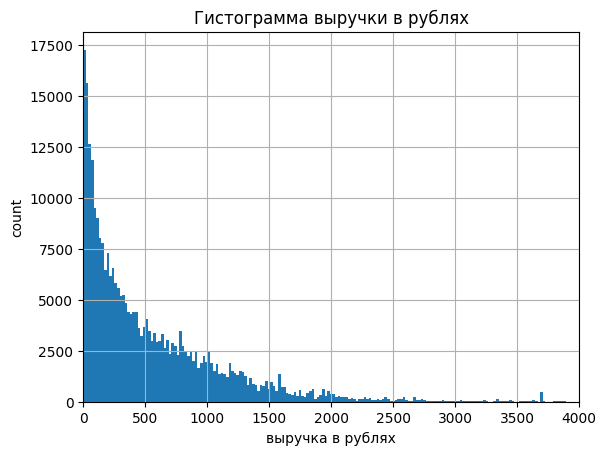

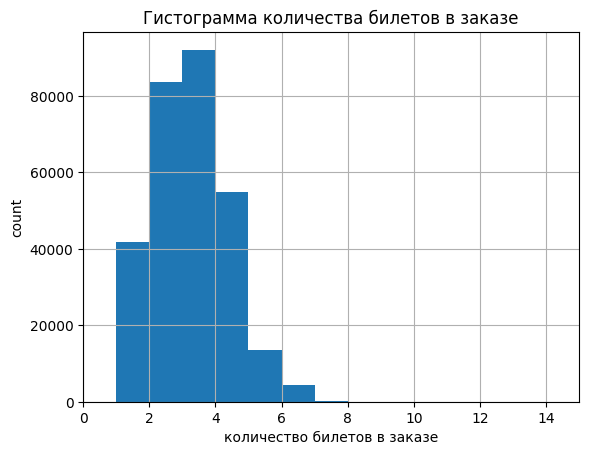

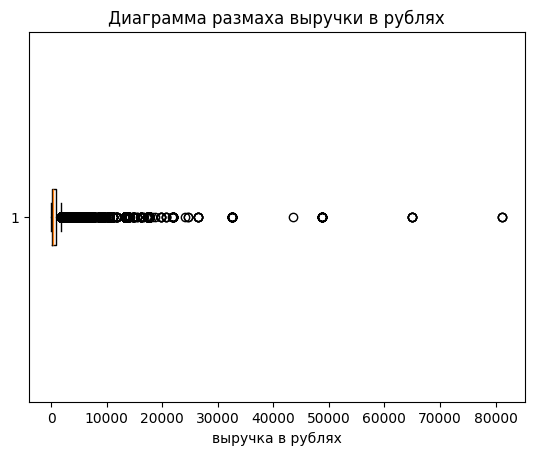

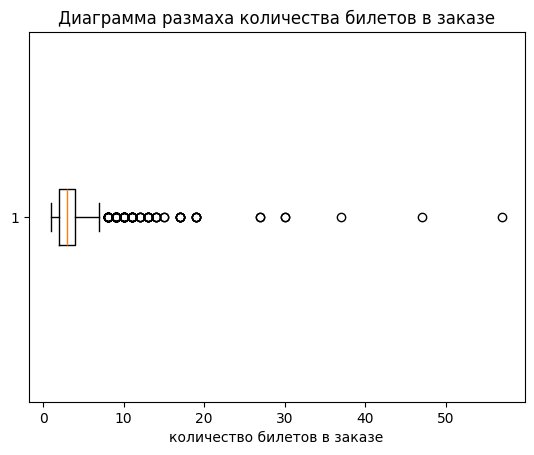

In [10]:
# Распределения и выбросы (гистограммы + boxplot)
print("\nОписательная статистика по ключевым числовым полям:")
display(df[['revenue_rub','tickets_count']].describe())

plt.figure()
df['revenue_rub'].hist(bins='auto')
plt.title('Гистограмма выручки в рублях')
plt.xlabel('выручка в рублях'); plt.ylabel('count')
plt.xlim(0, 4000)  # <-- ограничиваем ось X для лучшей визуализации
plt.show()

plt.figure()
df['tickets_count'].hist(bins='auto')
plt.title('Гистограмма количества билетов в заказе')
plt.xlabel('количество билетов в заказе'); plt.ylabel('count')
plt.xlim(0, 15) 
plt.show()

#диаграмма размаха с выбросами
plt.figure()
plt.boxplot(df['revenue_rub'].dropna(), vert=False)
plt.title('Диаграмма размаха выручки в рублях')
plt.xlabel('выручка в рублях')
plt.show()

#диаграмма размаха с выбросами
plt.figure()
plt.boxplot(df['tickets_count'].dropna(), vert=False)
plt.title('Диаграмма размаха количества билетов в заказе')
plt.xlabel('количество билетов в заказе')
plt.show()

In [11]:
# Одновременная фильтрация по 99-му перцентилю revenue_rub и tickets_count (создаём копию датафрейма)
p99_revenue = df['revenue_rub'].quantile(0.99)
p99_tickets = df['tickets_count'].quantile(0.99)

df_filtered = df[
    (df['revenue_rub'] <= p99_revenue) &
    (df['tickets_count'] <= p99_tickets)
].copy()

print(f"99-й перцентиль revenue_rub: {p99_revenue:.2f}")
print(f"99-й перцентиль tickets_count: {p99_tickets:.2f}")


print(f"Размер исходного датафрейма: {df.shape[0]} строк")
print(f"Размер датафрейма после удаления выбросов: {df_filtered.shape[0]} строк")
print(f"Удалено строк: {df.shape[0] - df_filtered.shape[0]}")
print(f"Удалено строк: {(df.shape[0] - df_filtered.shape[0])/len(df):.2%}")
# Финальная сводка
print("Размер набора данных:", df_filtered.shape)


99-й перцентиль revenue_rub: 4017.97
99-й перцентиль tickets_count: 6.00
Размер исходного датафрейма: 290230 строк
Размер датафрейма после удаления выбросов: 287141 строк
Удалено строк: 3089
Удалено строк: 1.06%
Размер набора данных: (287141, 16)


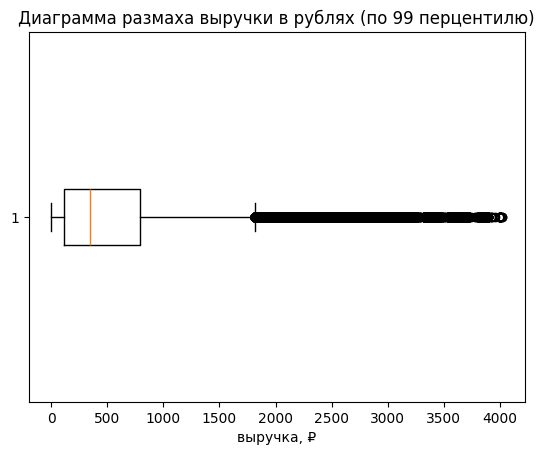

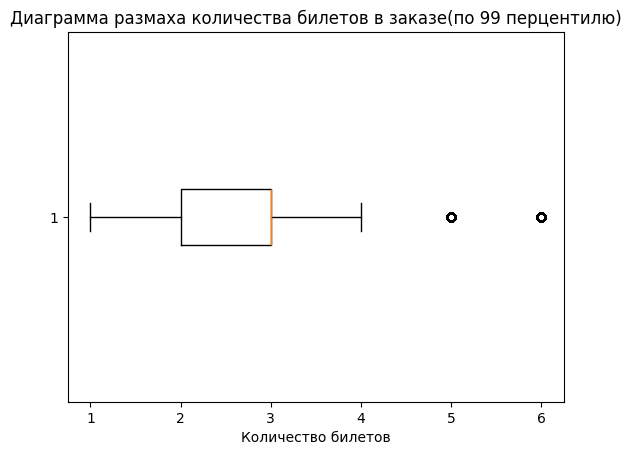

In [12]:
# Создаём диаграммы размаха по новому датафрейму для лучшей наглядности
# Boxplot для revenue_rub
plt.figure()
plt.boxplot(df_filtered['revenue_rub'], vert=False)
plt.title('Диаграмма размаха выручки в рублях (по 99 перцентилю)')
plt.xlabel('выручка, ₽')
plt.show()

# Boxplot для tickets_count
#plt.subplot(1, 2, 2)
plt.figure()
plt.boxplot(df_filtered['tickets_count'], vert=False)
plt.title('Диаграмма размаха количества билетов в заказе(по 99 перцентилю)')
plt.xlabel('Количество билетов')
plt.show()

Вывод:

Пропуски присутствуют только в столбце days_since_prev, что соответствует ожиданиям.

Типы данных оптимизированы:
числовые данные — понижена разрядность до подходящей,
категориальные признаки приведены к типу category. Столбцы с датой и временем имеют корректный тип данных datetime64.
Среди категорий отсутствуют категории обозначающие пропуски в данных или отсутствие информации. В числовом столбце revenue_rub обнаружены 381 строки с  отрицательными значениями, что может быть связано с возвратами билетов. Эти данные составляют всего 0.1311% от общего количества и исключены из анализа.
Для числовых показателей выручки в рублях и количества билетов приведена описательная статистика и построены гистограммы распределения и диаграммы размаха. 

По данным "Выручка в рублях":
среднее значение=626 сильно выше медианного=357 → распределение право-скошенное (много малых чеков и длинный дорогой “хвост”).
min=0 — возможны бесплатные/промо-билеты, возвраты, компенсации. Это не ошибка, но стоит учесть в анализе. max=81 174 при 75%=810 и таком std указывает на выбросы. Это подтверждает необходимость отсечения по p99.

Данные "Количество билетов в заказе":
median=3, IQR от 2 до 4 — типичный заказ 2–4 билета.
max=57 — вероятны групповые покупки/корпоративы. Их доля, как правило, мала, но они искажают метрики; для устойчивости можно также ограничить по p99.
Выбросы обнаруженные в столбце выручка в рублях и количество билетов отсечены по 99-му перцентилю,
при этом создана отдельная таблица df_filtered (исходный df не изменён). Объём очищенных данных:(287141 строк, 16 столбцов)Удалено строк: 3089
Удалено строк: 1.06%

Набор данных подготовлен для анализа пользовательских профилей.

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [13]:
# Отсортируем данные по времени заказа (и по order_id для устойчивости при совпадении времени)
df_sorted = df_filtered.sort_values(['user_id', 'order_ts', 'order_id'])

In [14]:
# 1) Признаки первого заказа пользователя
# Берём первую запись каждого пользователя после сортировки
first_order = (
    df_sorted
    .drop_duplicates(subset='user_id', keep='first')
    .loc[:, ['user_id',
             'order_ts',                
             'device_type_canonical',  
             'region_name',             
             'service_name',            
             'event_type_main']]        
    .rename(columns={
        'order_ts': 'first_order_ts',
        'device_type_canonical': 'first_device',
        'region_name': 'first_region',
        'service_name': 'first_partner',
        'event_type_main': 'first_event_type'
    })
)
# 2) Дата последнего заказа + агрегаты по пользователю
agg_part = (
    df_sorted
    .groupby('user_id', observed=True)
    .agg(
        last_order_ts=('order_ts', 'max'),
        total_orders=('order_id', 'nunique'),
        avg_revenue_per_order=('revenue_rub', 'mean'),
        avg_tickets_per_order=('tickets_count', 'mean'),
    )
    .reset_index()
)
# 3) Среднее время между заказами (в днях)
# Считаем разницы во времени между соседними заказами по каждому пользователю
df_sorted['order_ts_diff_days'] = (
    df_sorted
    .groupby('user_id', observed=True)['order_ts']
    .diff()
    .dt.total_seconds()
    .div(86400)  # секунд в сутках
)

mean_gap = (
    df_sorted
    .groupby('user_id', observed=True)['order_ts_diff_days']
    .mean()  # NaN для пользователей с 1 заказом — это корректно
    .reset_index()
    .rename(columns={'order_ts_diff_days': 'mean_days_between_orders'})
)
# 4) Объединим все части профиля
user_profile = (
    first_order
    .merge(agg_part, on='user_id', how='inner')
    .merge(mean_gap, on='user_id', how='left')
)
# 5) Бинарные признаки: is_two (>=2 заказа), is_five (>=5 заказов)
user_profile['is_two']  = (user_profile['total_orders'] >= 2)
user_profile['is_five'] = (user_profile['total_orders'] >= 5)

# Упорядочим столбцы для удобного просмотра
cols_order = [
    'user_id',
    'first_order_ts', 'last_order_ts',
    'first_device', 'first_region', 'first_partner', 'first_event_type',
    'total_orders', 'avg_revenue_per_order', 'avg_tickets_per_order',
    'mean_days_between_orders',
    'is_two', 'is_five'
]
user_profile = user_profile.loc[:, cols_order]

# 6) Просмотр результата
display(user_profile.head(10))
print(f'Профиль сформирован для пользователей: {user_profile.shape[0]}')

,user_id,first_order_ts,last_order_ts,first_device,first_region,first_partner,first_event_type,total_orders,avg_revenue_per_order,avg_tickets_per_order,mean_days_between_orders,is_two,is_five
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,NaN,False,False
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,74.805301,True,False
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,50.906667,True,False
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,NaN,False,False
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,15.617963,True,False
5,000cf0659a9f40f,2024-06-20 10:35:26,2024-06-21 04:36:17,mobile,Широковская область,Лови билет!,концерты,13,1175.808462,3.307692,0.062549,True,True
6,00147c9209d45d3,2024-06-25 23:26:58,2024-06-25 23:28:52,mobile,Каменевский регион,Облачко,концерты,2,352.945000,1.500000,0.001319,True,False
7,0018ecd8a38a51b,2024-07-25 20:38:57,2024-07-25 20:38:57,mobile,Медовская область,Билеты без проблем,спорт,1,0.000000,3.000000,NaN,False,False
8,00199a573901564,2024-06-17 22:58:15,2024-06-17 22:58:15,mobile,Каменевский регион,Билеты без проблем,концерты,1,588.120000,4.000000,NaN,False,False
9,001e7037d013f0f,2024-07-04 08:06:44,2024-09-29 22:58:14,mobile,Златопольский округ,Мой билет,другое,3,326.623333,1.333333,43.809549,True,False


Профиль сформирован для пользователей: 21745


Профиль 21745 пользователей успешно сформирован

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [15]:
# Общее число пользователей в выборке
total_users = user_profile['user_id'].nunique()

# Средняя выручка с одного заказа (берём среднее по пользователям)
avg_revenue_per_order = user_profile['avg_revenue_per_order'].mean()

# Доля пользователей, совершивших 2 и более заказа
share_two_plus = user_profile['is_two'].mean()

# Доля пользователей, совершивших 5 и более заказов
share_five_plus = user_profile['is_five'].mean()

# Выводим результаты
print(f"Общее число пользователей: {total_users:,}")
print(f"Средняя выручка с одного заказа (RUB): {avg_revenue_per_order:.2f}")
print(f"Доля пользователей с ≥2 заказами: {share_two_plus:.2%}")
print(f"Доля пользователей с ≥5 заказами: {share_five_plus:.2%}")


Общее число пользователей: 21,745
Средняя выручка с одного заказа (RUB): 574.87
Доля пользователей с ≥2 заказами: 61.74%
Доля пользователей с ≥5 заказами: 29.08%


База выглядит репрезентативной. 

21 745 пользователей — достаточный объём для устойчивых выводов.

Средний чек ≈ 575 ₽ (по средним чеков пользователей) — разумный уровень.

Повторные ≥2 заказа: 61.74% — высокая доля возвратов, аудитория лояльная.

Супер-лояльные ≥5 заказов: 29.08% — почти треть.

In [16]:
# Базовая описательная статистика по ключевым показателям профиля
key_cols = ['total_orders', 'avg_tickets_per_order', 'mean_days_between_orders']
print("Описательная статистика по профилю пользователей")
display(user_profile[key_cols].describe())

Описательная статистика по профилю пользователей


,total_orders,avg_tickets_per_order,mean_days_between_orders
count,21745.000000,21745.000000,13426.000000
mean,13.204921,2.745146,15.885681
std,121.941659,0.910968,22.340334
min,1.000000,1.000000,0.000012
25%,1.000000,2.000000,1.050857
50%,2.000000,2.750000,8.119270
75%,5.000000,3.111111,20.539062
max,10179.000000,6.000000,148.227755


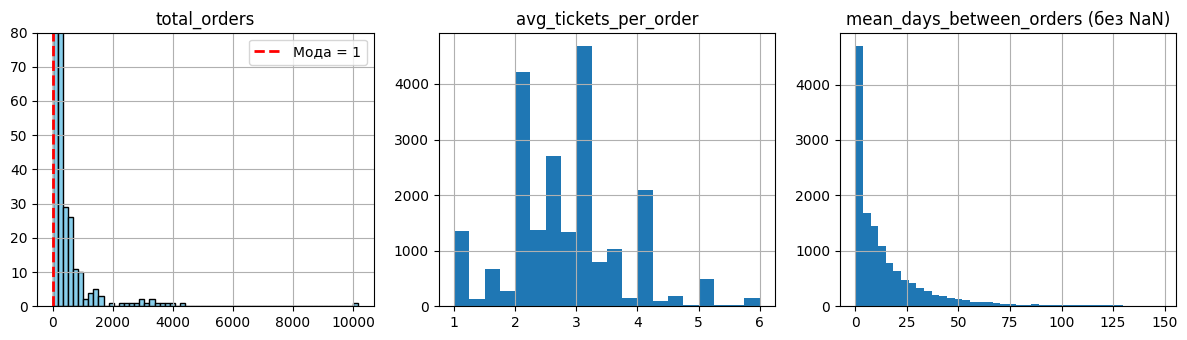

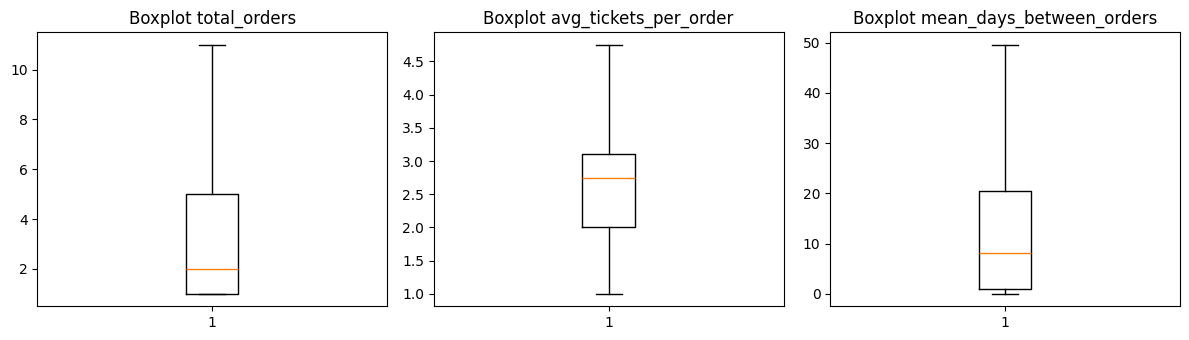

In [17]:
# Визуальная оценка распределений (гистограммы + boxplot)

plt.figure(figsize=(12, 3.5))
plt.subplot(1, 3, 1)
user_profile['total_orders'].hist(bins=60, color='skyblue', edgecolor='black')
plt.title('total_orders')
plt.ylim(0, 80)

# Найдём моду
mode_value = user_profile['total_orders'].mode()[0]

plt.axvline(mode_value, color='red', linestyle='--', linewidth=2, label=f'Мода = {mode_value}')
plt.legend()

plt.subplot(1, 3, 2)
user_profile['avg_tickets_per_order'].hist(bins=20)
plt.title('avg_tickets_per_order')

plt.subplot(1, 3, 3)
user_profile['mean_days_between_orders'].dropna().hist(bins=40)
plt.title('mean_days_between_orders (без NaN)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3.5))
plt.subplot(1, 3, 1)
plt.boxplot(user_profile['total_orders'].dropna(), vert=True,showfliers=False)
plt.title('Boxplot total_orders')

plt.subplot(1, 3, 2)
plt.boxplot(user_profile['avg_tickets_per_order'].dropna(), vert=True,showfliers=False)
plt.title('Boxplot avg_tickets_per_order')

plt.subplot(1, 3, 3)
plt.boxplot(user_profile['mean_days_between_orders'].dropna(), vert=True,showfliers=False)
plt.title('Boxplot mean_days_between_orders')
plt.tight_layout()
plt.show()

In [18]:
# 1) Посчитаем пороги p95/p99
p95_orders = user_profile['total_orders'].quantile(0.95)
p99_orders = user_profile['total_orders'].quantile(0.99)

p95_tickets = user_profile['avg_tickets_per_order'].quantile(0.95)
p99_tickets = user_profile['avg_tickets_per_order'].quantile(0.99)

print(f"total_orders: p95={p95_orders:.0f}, p99={p99_orders:.0f}")
print(f"avg_tickets_per_order: p95={p95_tickets:.2f}, p99={p99_tickets:.2f}")

# 2) Посмотрим верхние хвосты (сколько пользователей выше порога)
tail_orders_p99 = (user_profile['total_orders'] > p99_orders).sum()
tail_tickets_p99 = (user_profile['avg_tickets_per_order'] > p99_tickets).sum()

print(f"Пользователей с total_orders > p99: {tail_orders_p99} "
      f"({tail_orders_p99/len(user_profile):.2%})")
print(f"Пользователей с avg_tickets_per_order > p99: {tail_tickets_p99} "
      f"({tail_tickets_p99/len(user_profile):.2%})")

# 3) Фильтрация: по p99 для total_orders.
mask_orders = user_profile['total_orders'] <= p99_orders

user_profile_filtered = user_profile[mask_orders].copy()

print(f"\nРазмер до фильтрации: {len(user_profile):,}")
print(f"Размер после фильтрации по total_orders<=p99: {len(user_profile_filtered):,}")
print(f"Удалено: {len(user_profile) - len(user_profile_filtered)} "
      f"({(len(user_profile) - len(user_profile_filtered))/len(user_profile):.2%})")

# 4) Сравнение описательной статистики «до/после»
cols = ['total_orders', 'avg_tickets_per_order', 'mean_days_between_orders']
print("\nОписательная статистика ДО:")
display(user_profile[cols].describe())

print("Описательная статистика ПОСЛЕ (user_profile_filtered):")
display(user_profile_filtered[cols].describe())


total_orders: p95=32, p99=152
avg_tickets_per_order: p95=4.00, p99=5.00
Пользователей с total_orders > p99: 218 (1.00%)
Пользователей с avg_tickets_per_order > p99: 190 (0.87%)

Размер до фильтрации: 21,745
Размер после фильтрации по total_orders<=p99: 21,527
Удалено: 218 (1.00%)

Описательная статистика ДО:


,total_orders,avg_tickets_per_order,mean_days_between_orders
count,21745.000000,21745.000000,13426.000000
mean,13.204921,2.745146,15.885681
std,121.941659,0.910968,22.340334
min,1.000000,1.000000,0.000012
25%,1.000000,2.000000,1.050857
50%,2.000000,2.750000,8.119270
75%,5.000000,3.111111,20.539062
max,10179.000000,6.000000,148.227755


Описательная статистика ПОСЛЕ (user_profile_filtered):


,total_orders,avg_tickets_per_order,mean_days_between_orders
count,21527.000000,21527.000000,13208.000000
mean,6.488689,2.745286,16.140136
std,14.239834,0.915414,22.435229
min,1.000000,1.000000,0.000012
25%,1.000000,2.000000,1.387724
50%,2.000000,2.750000,8.424017
75%,5.000000,3.125000,20.830824
max,151.000000,6.000000,148.227755


Вывод:
Объём данных достаточный (21.7k профилей) и репрезентативный.Размер до фильтрации: 21,745 
Аномальные значения:
В total_orders есть редкие экстремальные наблюдения (до 10k+), искажающие средние (единичные экстремальные значения до 10179, вероятно, корпоративные/агрегированные аккаунты, тестовые/служебные записи и т.д.) — мы отсекли p99, потеря данных незначительна (выведено в процентах).

avg_tickets_per_order имеет разумный диапазон (IQR ~2.0–3.1; max=6) распределение компактное. Отсечение по p99 можно не делать (хвост короткий),

mean_days_between_orders не фильтруем — длинные интервалы отражают пользовательское поведение; NaN у первой покупки — норма.

Все ключевые статистики пересчитаны на user_profile_filtered — метрики стали устойчивее (медианы/квантили ближе к центру распределения).

Размер до фильтрации: 21,745
Размер после фильтрации по total_orders<=p99: 21,527 Удалено: 218 записей (1.00%)

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


Всего пользователей: 21,527


,first_event_type,users,share
2,концерты,9371,0.435314
1,другое,5449,0.253124
5,театр,4284,0.199006
4,стендап,1117,0.051888
3,спорт,800,0.037163
0,выставки,411,0.019092
6,ёлки,95,0.004413


,first_device,users,share
1,mobile,17849,0.829145
0,desktop,3678,0.170855


,first_region,users,share
23,Каменевский регион,7152,0.332234
60,Североярская область,3785,0.175826
77,Широковская область,1239,0.057556
45,Озернинский край,682,0.031681
41,Малиновоярский округ,542,0.025178
74,Травяная область,489,0.022716
57,Светополянский округ,468,0.021740
52,Речиновская область,441,0.020486
78,Яблоневская область,414,0.019232
42,Медовская область,375,0.017420


,first_partner,users,share
3,Билеты без проблем,5170,0.240164
19,Лови билет!,2836,0.131742
22,Мой билет,2756,0.128025
4,Билеты в руки,2563,0.119060
23,Облачко,2196,0.102011
7,Весь в билетах,1307,0.060714
20,Лучшие билеты,1189,0.055233
24,Прачечная,593,0.027547
17,Край билетов,457,0.021229
12,Дом культуры,358,0.016630


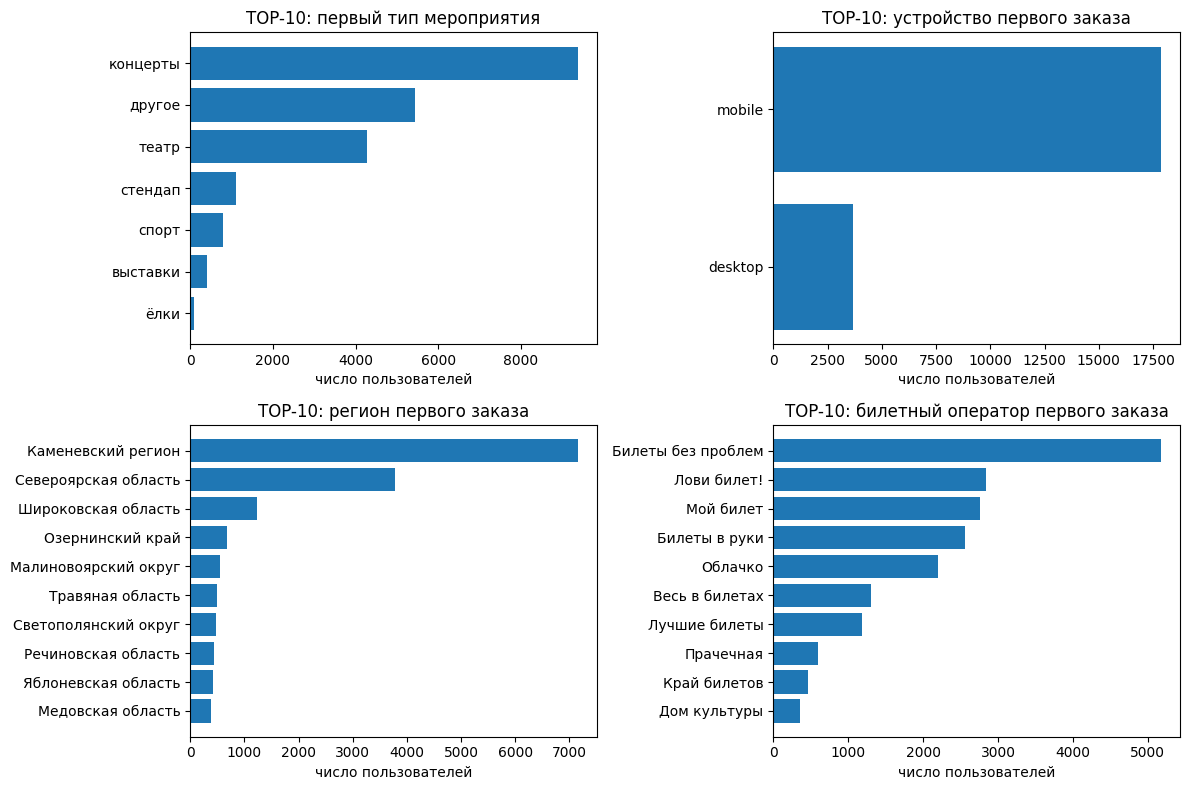


Концентрация пользователей (доли ТОП-3 сегментов):
first_event_type: 88.74%
first_device    : 100.00%
first_region    : 56.56%
first_partner   : 49.99%


In [19]:
# Распределение пользователей по признакам 
base = user_profile_filtered.copy()

def seg_table(df, col, top_n=10):
    """Сводная по сегментам: count, share; отсортирована по count."""
    total = df['user_id'].nunique()
    tbl = (df
           .groupby(col, dropna=False,observed=True)['user_id']
           .nunique()
           .reset_index(name='users'))
    tbl['share'] = tbl['users'] / total
    tbl = tbl.sort_values('users', ascending=False, kind='mergesort')
    return tbl, total

# 1) По типу первого мероприятия
event_tbl, total_users = seg_table(base, 'first_event_type')
print(f"Всего пользователей: {total_users:,}")
display(event_tbl.head(10))

# 2) По типу устройства первого заказа
device_tbl, _ = seg_table(base, 'first_device')
display(device_tbl.head(10))

# 3) По региону первого заказа
region_tbl, _ = seg_table(base, 'first_region')
display(region_tbl.head(10))

# 4) По билетному оператору первого заказа
partner_tbl, _ = seg_table(base, 'first_partner')
display(partner_tbl.head(10))

# визуализация ТОП-10 сегментов по каждому признаку
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, (tbl, title, colname) in zip(
    axes.ravel(),
    [
        (event_tbl.head(10),  'TOP-10: первый тип мероприятия', 'first_event_type'),
        (device_tbl.head(10), 'TOP-10: устройство первого заказа', 'first_device'),
        (region_tbl.head(10), 'TOP-10: регион первого заказа', 'first_region'),
        (partner_tbl.head(10),'TOP-10: билетный оператор первого заказа', 'first_partner'),
    ]
):
    ax.barh(tbl[colname].astype(str), tbl['users'])
    ax.set_title(title)
    ax.invert_yaxis()
    ax.set_xlabel('число пользователей')
plt.tight_layout()
plt.show()

# Дополнительно: быстро посмотрим «концентрацию входа» — доля ТОП сегментов
def top_concentration(tbl, k=3):
    return tbl['share'].head(k).sum()

print("\nКонцентрация пользователей (доли ТОП-3 сегментов):")
print("first_event_type:", f"{top_concentration(event_tbl, 3):.2%}")
print("first_device    :", f"{top_concentration(device_tbl, 3):.2%}")
print("first_region    :", f"{top_concentration(region_tbl, 3):.2%}")
print("first_partner   :", f"{top_concentration(partner_tbl, 3):.2%}")


Тип первого мероприятия (first_event_type): распределение сильно неравномерное.
Главные «точки входа» — концерты, «другое» (объединённая категория) и театр.
На них приходится более 88 % первых покупок. Остальные жанры — нишевые.

Устройство первого заказа (first_device): явная доминация мобильных устройств — это главная точка входа в сервис.
Доля desktop-пользователей менее 20 %, что логично для современной аудитории.

Регион первого заказа (first_region): аудитория сконцентрирована в двух крупных регионах — Каменевский и Североярская области формируют более 50 % всех первых покупок. Это ярко выраженные географические «точки входа».

Билетный партнёр (first_partner): рынок партнёров фрагментирован, но первые 5 компаний обеспечивают около 72 % всех новых пользователей.
Главная точка входа — «Билеты без проблем» (24 %), далее — «Лови билет!» и «Мой билет».

Итоговый вывод по задаче:

Распределения по всем признакам неравномерные, есть выраженные точки входа:

по жанрам — концерты,театр и другое;

по устройствам — мобильные;

по регионам — 2 крупных региона (Каменевский и Североярская);

по партнёрам — несколько крупных билетных агрегаторов.

Это говорит о том, что большинство новых клиентов приходят из ограниченного числа каналов/сегментов.

Для маркетинга и аналитики стоит выделить именно эти доминирующие сегменты как основные «ворота» в сервис и отдельно изучить, возвращаются ли пользователи из них чаще других.

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


Базовая доля возврата (в среднем по выборке): 61.36%


,first_event_type,users,repeaters,return_rate,share
2,концерты,9371,5786,0.617437,0.435314
1,другое,5449,3250,0.596440,0.253124
5,театр,4284,2726,0.636321,0.199006
4,стендап,1117,682,0.610564,0.051888
3,спорт,800,449,0.561250,0.037163
0,выставки,411,263,0.639903,0.019092
6,ёлки,95,52,0.547368,0.004413


,first_device,users,repeaters,return_rate,share
1,mobile,17849,10867,0.608830,0.829145
0,desktop,3678,2341,0.636487,0.170855


,first_region,users,repeaters,return_rate,share
23,Каменевский регион,7152,4475,0.625699,0.332234
60,Североярская область,3785,2426,0.640951,0.175826
77,Широковская область,1239,803,0.648103,0.057556
45,Озернинский край,682,378,0.554252,0.031681
41,Малиновоярский округ,542,307,0.566421,0.025178
...,...,...,...,...,...
56,Светолесский край,2,1,0.500000,0.000093
70,Тихогорская область,2,1,0.500000,0.000093
5,Верхозёрский край,1,1,1.000000,0.000046
66,Сосноводолинская область,1,0,0.000000,0.000046


,first_partner,users,repeaters,return_rate,share
3,Билеты без проблем,5170,3136,0.606576,0.240164
19,Лови билет!,2836,1737,0.612482,0.131742
22,Мой билет,2756,1633,0.592525,0.128025
4,Билеты в руки,2563,1613,0.629341,0.119060
23,Облачко,2196,1353,0.616120,0.102011
7,Весь в билетах,1307,826,0.631982,0.060714
20,Лучшие билеты,1189,731,0.614802,0.055233
24,Прачечная,593,373,0.629005,0.027547
17,Край билетов,457,299,0.654267,0.021229
12,Дом культуры,358,233,0.650838,0.016630


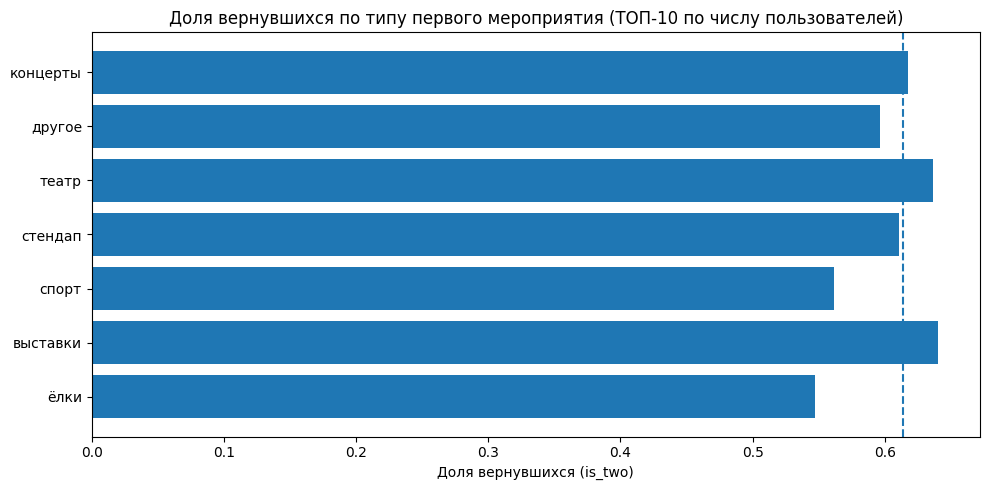

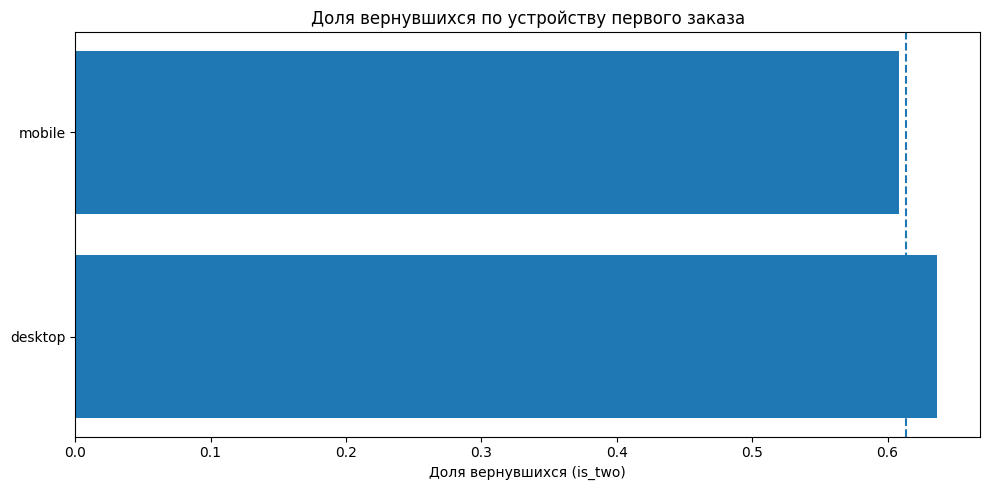

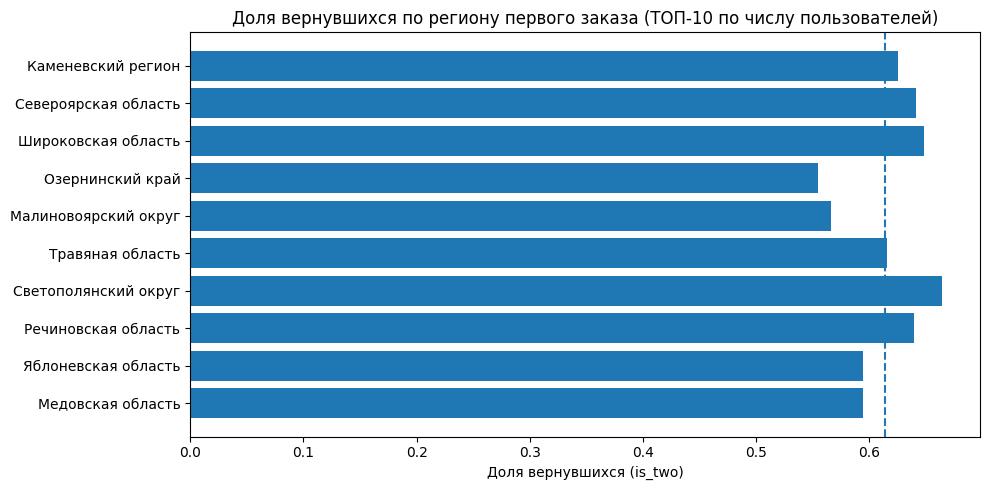

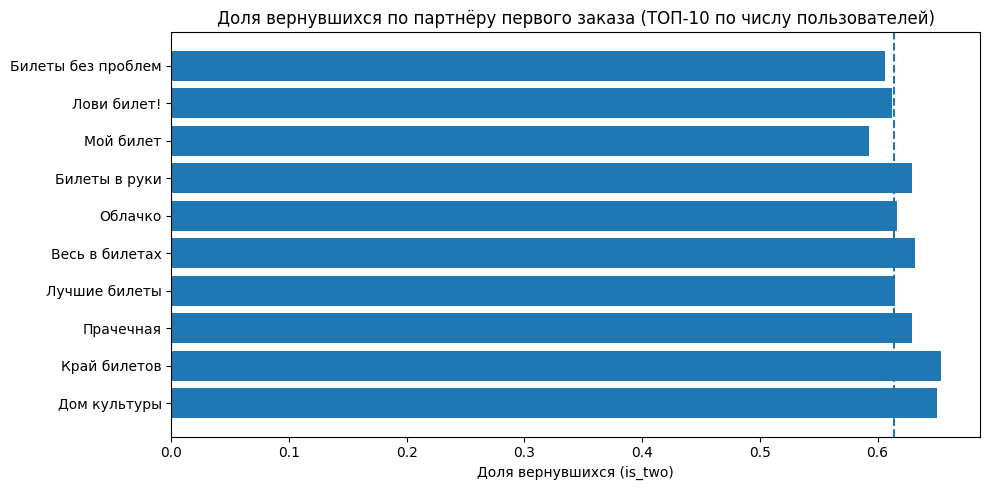


ТОП-10 сегментов по доле возврата — first_event_type (users ≥ 100):


,first_event_type,users,share,return_rate
0,выставки,411,0.019092,0.639903
5,театр,4284,0.199006,0.636321
2,концерты,9371,0.435314,0.617437
4,стендап,1117,0.051888,0.610564
1,другое,5449,0.253124,0.596440
3,спорт,800,0.037163,0.561250



ТОП-10 сегментов по доле возврата — first_device (users ≥ 100):


,first_device,users,share,return_rate
0,desktop,3678,0.170855,0.636487
1,mobile,17849,0.829145,0.608830



ТОП-10 сегментов по доле возврата — first_region (users ≥ 100):


,first_region,users,share,return_rate
57,Светополянский округ,468,0.021740,0.664530
11,Горицветская область,249,0.011567,0.662651
2,Берёзовская область,111,0.005156,0.657658
54,Речицкий регион,188,0.008733,0.654255
77,Широковская область,1239,0.057556,0.648103
18,Заречная область,204,0.009476,0.647059
60,Североярская область,3785,0.175826,0.640951
52,Речиновская область,441,0.020486,0.639456
7,Ветренский регион,153,0.007107,0.627451
23,Каменевский регион,7152,0.332234,0.625699



ТОП-10 сегментов по доле возврата — first_partner (users ≥ 100):


,first_partner,users,share,return_rate
17,Край билетов,457,0.021229,0.654267
1,Show_ticket,167,0.007758,0.652695
12,Дом культуры,358,0.016630,0.650838
21,Мир касс,208,0.009662,0.644231
7,Весь в билетах,1307,0.060714,0.631982
4,Билеты в руки,2563,0.119060,0.629341
24,Прачечная,593,0.027547,0.629005
23,Облачко,2196,0.102011,0.616120
20,Лучшие билеты,1189,0.055233,0.614802
19,Лови билет!,2836,0.131742,0.612482


In [20]:
#  Доля вернувшихся пользователей (is_two) по сегментам 
# Базовая доля возврата по всей выборке (для справки на графиках)
overall_return_rate = base['is_two'].mean()
print(f"Базовая доля возврата (в среднем по выборке): {overall_return_rate:.2%}")

def segment_return_table(df, col, min_users_for_top=0):
    total_users = df['user_id'].nunique()
    tbl = (
        df.groupby(col, dropna=False, observed=True)
          .agg(users=('user_id','nunique'),
               repeaters=('is_two','sum'))
          .reset_index()
    )
    tbl['return_rate'] = tbl['repeaters'] / tbl['users']
    tbl['share'] = tbl['users'] / total_users
    tbl = tbl.sort_values('users', ascending=False, kind='mergesort')
    if min_users_for_top > 0:
        tbl = tbl[tbl['users'] >= min_users_for_top]
    return tbl, total_users

# 1) По типу первого мероприятия
event_tbl, total_users = segment_return_table(base, 'first_event_type')
display(event_tbl)

# 2) По типу устройства первого заказа
device_tbl, _ = segment_return_table(base, 'first_device')
display(device_tbl)

# 3) По региону первого заказа
region_tbl, _ = segment_return_table(base, 'first_region')
display(region_tbl)

# 4) По билетному оператору первого заказа
partner_tbl, _ = segment_return_table(base, 'first_partner')
display(partner_tbl)

# Если сегментов много — рисуем только ТОП-10 по числу пользователей.
def plot_top10(tbl, colname, title):
    top = tbl.head(10)
    plt.figure(figsize=(10, 5))
    plt.barh(top[colname].astype(str), top['return_rate'])
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel('Доля вернувшихся (is_two)')
    # линия среднего по выборке
    plt.axvline(overall_return_rate, linestyle='--')
    plt.tight_layout()
    plt.show()

# Графики
plot_top10(event_tbl,   'first_event_type',  'Доля вернувшихся по типу первого мероприятия (ТОП-10 по числу пользователей)')
plot_top10(device_tbl,  'first_device',      'Доля вернувшихся по устройству первого заказа')
plot_top10(region_tbl,  'first_region',      'Доля вернувшихся по региону первого заказа (ТОП-10 по числу пользователей)')
plot_top10(partner_tbl, 'first_partner',     'Доля вернувшихся по партнёру первого заказа (ТОП-10 по числу пользователей)')

# Ограничим минимальный размер сегмента, чтобы избежать нестабильных долей (например, >= 100 пользователей).
MIN_USERS = 100

def top_segments_by_return(tbl, label, k=10, min_users=MIN_USERS):
    cand = tbl[tbl['users'] >= min_users].sort_values('return_rate', ascending=False)
    print(f"\nТОП-{k} сегментов по доле возврата — {label} (users ≥ {min_users}):")
    display(cand.head(k)[[label, 'users', 'share', 'return_rate']])

top_segments_by_return(event_tbl,  'first_event_type')
top_segments_by_return(device_tbl, 'first_device')
top_segments_by_return(region_tbl, 'first_region')
top_segments_by_return(partner_tbl,'first_partner')


Вывод:

Кто возвращается чаще среднего:
Тип первого мероприятия:выставки, театр, концерты 
Устройство первого заказа: Desktop 
Регион первого заказа: Светополянский округ , Горицветская область и Берёзовская область
Билетный партнёр первого заказа: Край билетов , Show_ticket,Дом культуры и др.
Есть ли «успешные точки входа»?
Да. Сегменты, где доля возврата выше 61.36% и при этом заметная доля пользователей:
Театр (жанр первого заказа).
Desktop (устройство, хоть и меньшинство, но с лучшим удержанием).
Регионы: Североярская, Широковская, также Каменевский (чуть выше среднего и крупнейший по объёму).
Партнёры: Билеты в руки, Облачко, Весь в билетах.


---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [21]:
# Гипотеза 1  
# Оставим только два нужных сегмента
h1 = base[base['first_event_type'].isin(['спорт', 'концерты'])].copy()

# Групповая сводка: число пользователей и доля вернувшихся
h1_tbl = (h1
          .groupby('first_event_type', dropna=False, observed=True)
          .agg(users=('user_id','nunique'),
               repeaters=('is_two','sum'))
          .reset_index())
h1_tbl['return_rate'] = h1_tbl['repeaters'] / h1_tbl['users']
display(h1_tbl)

,first_event_type,users,repeaters,return_rate
0,концерты,9371,5786,0.617437
1,спорт,800,449,0.561250


Гипотеза 1 

Доли возврата: спорт 56.13% < концерты 61.74%.

Вывод: гипотеза не подтверждается — пользователи, начавшие со спортивных мероприятий, возвращаются реже, чем те, кто начал с концертов. 

In [22]:
#Гипотеза 2
region_stats = (
    base
    .groupby('first_region', observed=True)
    .agg(
        users=('user_id', 'nunique'),
        repeaters=('is_two', 'sum')
    )
    .reset_index()
)

# Доля пользователей, совершивших повторный заказ
region_stats['return_rate'] = region_stats['repeaters'] / region_stats['users']

# Сортируем по числу пользователей
region_stats = region_stats.sort_values('users', ascending=False)

# Вывод таблицы
display(region_stats.head(10))

print(f"Всего регионов в таблице: {region_stats.shape[0]}")


,first_region,users,repeaters,return_rate
23,Каменевский регион,7152,4475,0.625699
60,Североярская область,3785,2426,0.640951
77,Широковская область,1239,803,0.648103
45,Озернинский край,682,378,0.554252
41,Малиновоярский округ,542,307,0.566421
74,Травяная область,489,301,0.615542
57,Светополянский округ,468,311,0.664530
52,Речиновская область,441,282,0.639456
78,Яблоневская область,414,246,0.594203
42,Медовская область,375,223,0.594667


Всего регионов в таблице: 81


In [23]:
# считаем корреляцию:
pearson_corr = region_stats[['users', 'return_rate']].corr(method='pearson').loc['users', 'return_rate']
print(f"Pearson(users, return_rate) = {pearson_corr:.4f}")


Pearson(users, return_rate) = 0.1192


Гипотеза 2 не подтверждается.
Корреляция по Pearson = 0.1192 , значения от 0 до 0,3 означают слабую коррекляцию, то есть взаимосвязи практически нет.
Различия по регионам существуют, но являются умеренными.


---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


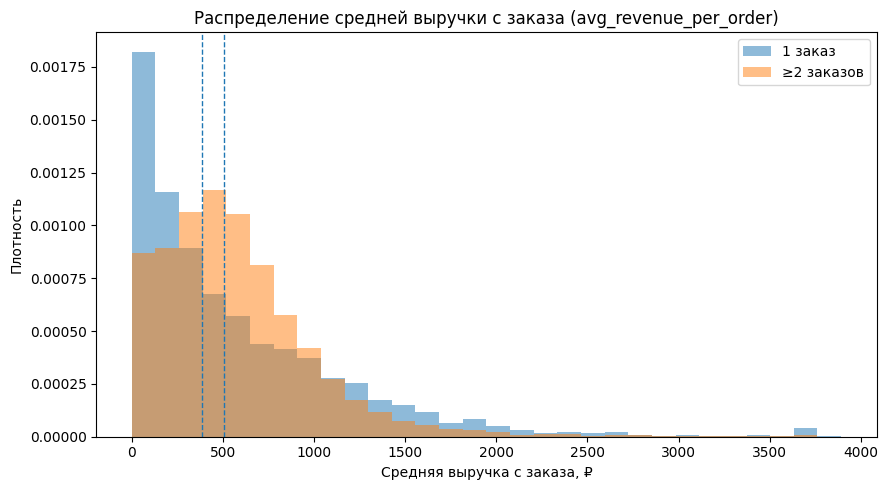

Сводка: 1 заказ -> {'count': 8319, 'mean': 578.2498545498257, 'median': 387.96, 'p25': 141.19, 'p75': 842.86}
Сводка: ≥2 заказов -> {'count': 13208, 'mean': 573.4276565542485, 'median': 504.78886363636366, 'p25': 280.5175, 'p75': 765.709976076555}


In [24]:
# Связь средней выручки с заказа и повторных покупок
# Разделим пользователей на группы
one_order = user_profile_filtered[user_profile_filtered['total_orders'] == 1]['avg_revenue_per_order'].dropna()
repeaters = user_profile_filtered[user_profile_filtered['total_orders'] >= 2]['avg_revenue_per_order'].dropna()

# Единые бины для сравнения распределений
all_vals = np.concatenate([one_order.values, repeaters.values])
bins = np.histogram_bin_edges(all_vals, bins=30)  # можно увеличить/уменьшить число бинов при желании

# Гистограммы 
plt.figure(figsize=(9, 5))
plt.hist(one_order, bins=bins, density=True, alpha=0.5, label='1 заказ')
plt.hist(repeaters, bins=bins, density=True, alpha=0.5, label='≥2 заказов')

med_one = np.median(one_order)
med_rep = np.median(repeaters)
plt.axvline(med_one, linestyle='--', linewidth=1)
plt.axvline(med_rep, linestyle='--', linewidth=1)

plt.title('Распределение средней выручки с заказа (avg_revenue_per_order)')
plt.xlabel('Средняя выручка с заказа, ₽')
plt.ylabel('Плотность')
plt.legend()
plt.tight_layout()
plt.show()

# Краткая числовая сводка по группам 
def summary_stats(s):
    return {
        'count': len(s),
        'mean': float(np.mean(s)),
        'median': float(np.median(s)),
        'p25': float(np.quantile(s, 0.25)),
        'p75': float(np.quantile(s, 0.75))
    }

sum_one = summary_stats(one_order)
sum_rep = summary_stats(repeaters)

print("Сводка: 1 заказ ->", sum_one)
print("Сводка: ≥2 заказов ->", sum_rep)


Диапазоны концентрации (p25–p75) и медианы

1 заказ: p25–p75 = 141–843 ₽, медиана ≈ 388 ₽.

≥2 заказов: p25–p75 = 281–766 ₽, медиана ≈ 505 ₽.

Есть ли различия между группами?
Да.
Медиана у пользователей сделавших более 2х заказов выше (≈ 505 ₽ против 388 ₽): типичный средний чек у вернувшихся пользователей больше.
Форма распределений различается: у группы с 1 заказом межквартильный размах шире и смещён левее (много очень дешёвых заказов), но при этом верхний квартиль выше (p75=843 ₽ против 766 ₽), а среднее даже чуть выше (578 ₽ vs 573 ₽). Это указывает на более тяжёлый правый хвост у одноразовых покупателей (есть редкие, но очень дорогие заказы).
У вернувшихся распределение более «компактное» и сместилось вправо в центральной части: меньше совсем дешёвых заказов, больше «средних по цене».

Итог: пользователи, которые возвращаются, в среднем делают более дорогие типичные заказы (выше медиана), но среди пользователей с одним заказом встречаются и очень дорогие единичные покупки, из-за чего у них шире размах и чуть выше среднее.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


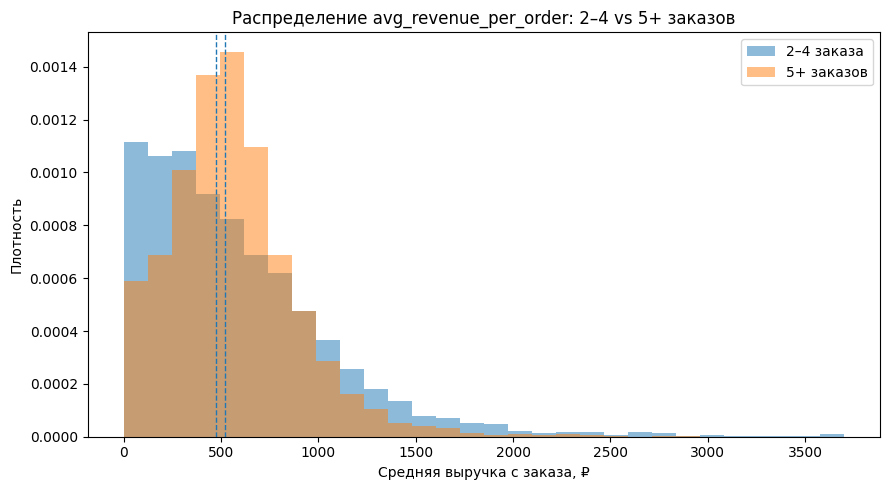

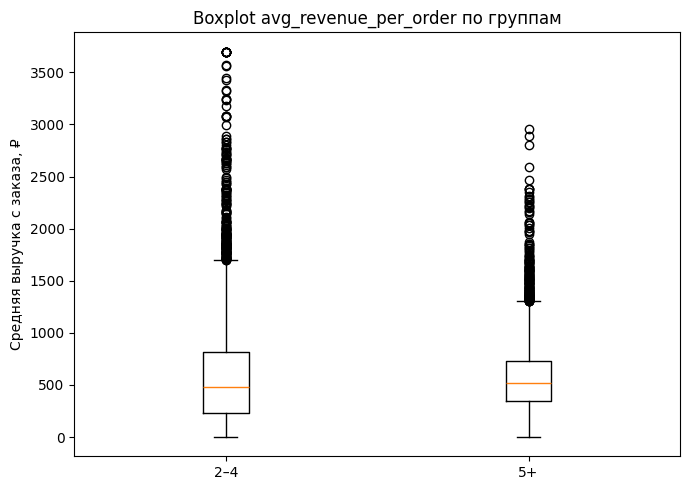

Сводка — 2–4 заказа: {'count': 7103, 'mean': 584.2202447322728, 'median': 476.985, 'p25': 228.5275, 'p75': 817.2866666666666}
Сводка — 5+ заказов: {'count': 6105, 'mean': 560.8707763202589, 'median': 522.659, 'p25': 341.57722222222225, 'p75': 726.1467567567568}


In [25]:
# Средняя выручка с заказа: 2–4 vs 5+ заказов 
# Разбивка на группы
grp_2_4 = user_profile_filtered[
    (user_profile_filtered['total_orders'] >= 2) & (user_profile_filtered['total_orders'] <= 4)
]['avg_revenue_per_order'].dropna()

grp_5p = user_profile_filtered[
    (user_profile_filtered['total_orders'] >= 5)
]['avg_revenue_per_order'].dropna()

# Общие бины для сопоставимых гистограмм
all_vals = np.concatenate([grp_2_4.values, grp_5p.values])
bins = np.histogram_bin_edges(all_vals, bins=30)

# Гистограммы
plt.figure(figsize=(9,5))
plt.hist(grp_2_4, bins=bins, density=True, alpha=0.5, label='2–4 заказа')
plt.hist(grp_5p,   bins=bins, density=True, alpha=0.5, label='5+ заказов')

# Медианы
med_24 = float(np.median(grp_2_4))
med_5p = float(np.median(grp_5p))
plt.axvline(med_24, linestyle='--', linewidth=1)
plt.axvline(med_5p, linestyle='--', linewidth=1)

plt.title('Распределение avg_revenue_per_order: 2–4 vs 5+ заказов')
plt.xlabel('Средняя выручка с заказа, ₽'); plt.ylabel('Плотность')
plt.legend(); plt.tight_layout(); plt.show()

# Boxplot
plt.figure(figsize=(7,5))
plt.boxplot([grp_2_4, grp_5p], tick_labels=['2–4', '5+'], vert=True)
plt.title('Boxplot avg_revenue_per_order по группам')
plt.ylabel('Средняя выручка с заказа, ₽')
plt.tight_layout(); plt.show()

# Сводная статистика
def summarize(x):
    return {
        'count': int(len(x)),
        'mean': float(np.mean(x)),
        'median': float(np.median(x)),
        'p25': float(np.quantile(x, 0.25)),
        'p75': float(np.quantile(x, 0.75))
    }

sum_24 = summarize(grp_2_4)
sum_5p = summarize(grp_5p)

print("Сводка — 2–4 заказа:", sum_24)
print("Сводка — 5+ заказов:", sum_5p)



Вывод:

2–4 заказа
IQR: 228.53–817.29 руб., медиана ≈ 476.99 руб., среднее ≈ 584.22 руб.

5+ заказов
IQR: 341.58–726.15 руб., медиана ≈ 522.66 руб., среднее ≈ 560.87 руб.

Видим различия по значению средней выручки с заказа между пользователями этих двух групп.
У группы 5+заказов медиана выше, а нижняя граница IQR заметно правее (341.6 руб. против 228.5 руб.). Это говорит, что «ядро» заказов у частых покупателей дороже.

При этом среднее у группы 5+заказов ниже, чем у группы 2–4 заказа (560.9 руб. vs 584.2 руб.) — признак того, что у группы 2–4 встречается больше редких очень дорогих заказов (тяжёлый правый хвост), которые тянут среднее вверх.

Итог: типичный чек (по медиане) выше у покупателей совершивших 5 и более заказов, но экстремально дорогие заказы чаще встречаются у группы 2–4 заказа.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

Описательная статистика avg_tickets_per_order:
 count    21527.000000
mean         2.745286
std          0.915414
min          1.000000
25%          2.000000
50%          2.750000
75%          3.125000
max          6.000000
Name: avg_tickets_per_order, dtype: float64


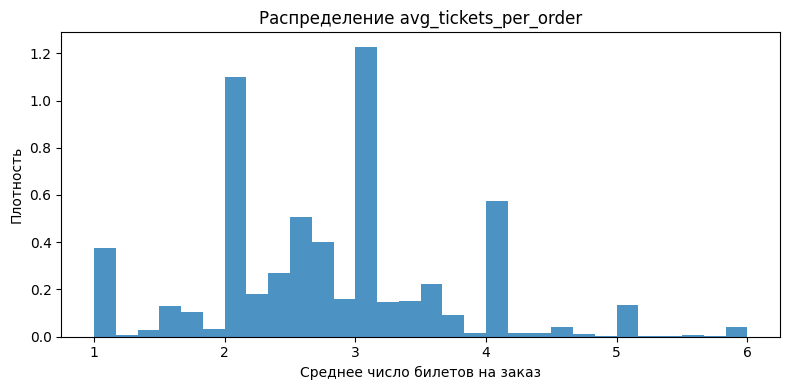

Базовая доля возврата по выборке: 61.36%


,tickets_segment,users,share,median_avg_tickets,return_rate
0,1–<2,2420,0.112417,1.000000,0.512397
1,2–<3,9406,0.436940,2.333333,0.732936
2,3–<5,9031,0.419520,3.187500,0.548112
3,5+,670,0.031124,5.000000,0.185075


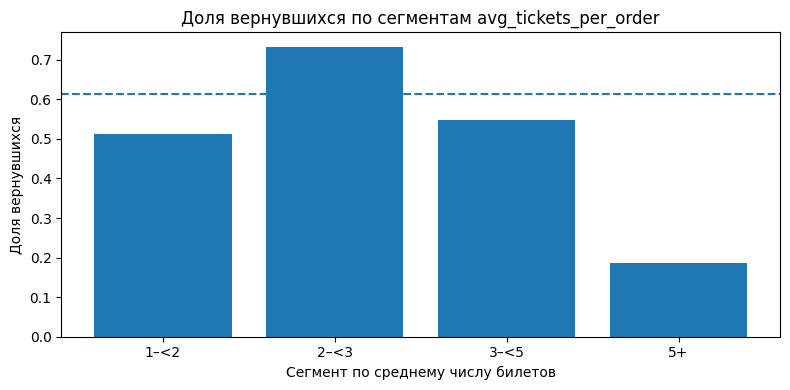

In [26]:
# Среднее число билетов и вероятность повтора 
# 1) Распределение avg_tickets_per_order
desc = base['avg_tickets_per_order'].describe()
print("Описательная статистика avg_tickets_per_order:\n", desc)

plt.figure(figsize=(8,4))
plt.hist(base['avg_tickets_per_order'].dropna(), bins=30, density=True, alpha=0.8)
plt.title('Распределение avg_tickets_per_order')
plt.xlabel('Среднее число билетов на заказ')
plt.ylabel('Плотность')
plt.tight_layout()
plt.show()

# 2) Сегментация по среднему числу билетов:
#    [1, 2), [2, 3), [3, 5), [5, +∞)
bins   = [1, 2, 3, 5, np.inf]
labels = ['1–<2', '2–<3', '3–<5', '5+']

base['tickets_segment'] = pd.cut(
    base['avg_tickets_per_order'],
    bins=bins, labels=labels, include_lowest=True, right=False
)

# 3) Таблица по сегментам: число пользователей, доля вернувшихся, доля сегмента
overall_return = base['is_two'].mean()

seg_tbl = (
    base.groupby('tickets_segment', observed=True)
        .agg(users=('user_id','nunique'),
             repeaters=('is_two','sum'),
             median_avg_tickets=('avg_tickets_per_order','median'))
        .reset_index()
        .sort_values('tickets_segment')
)
seg_tbl['return_rate'] = seg_tbl['repeaters'] / seg_tbl['users']
seg_tbl['share'] = seg_tbl['users'] / base['user_id'].nunique()

print(f"Базовая доля возврата по выборке: {overall_return:.2%}")
display(seg_tbl[['tickets_segment','users','share','median_avg_tickets','return_rate']])

# 4) Визуализация: доля вернувшихся по сегментам
plt.figure(figsize=(8,4))
plt.bar(seg_tbl['tickets_segment'].astype(str), seg_tbl['return_rate'])
plt.axhline(overall_return, linestyle='--')  
plt.title('Доля вернувшихся по сегментам avg_tickets_per_order')
plt.xlabel('Сегмент по среднему числу билетов')
plt.ylabel('Доля вернувшихся')
plt.tight_layout()
plt.show()


1) Распределение пользователей по среднему количеству билетов в заказе :
Центр распределения — 2–3 билета.
Медиана 2.75, среднее 2.75 говорят о том,что основная масса пользователей покупает в среднем ≈2–3 билета.
Распределение компактное.
Стандартное отклонение 0.92 при диапазоне 1–6 говорит, что большинство значений лежит близко к центру, крайние значения встречаются редко.
Присутствует некая «ступенчатость».
Показатель формируется из целых покупок, поэтому плотность выше возле «круглых» уровней (например, ~2.0, ~2.5–3.0). Это нормально для средней по заказам метрики.
Хвосты небольшие.
Минимум 1 (есть пользователи, кто стабильно берет по одному билету), максимум 6 (редко). 

2) Как распределены пользователи по сегментам?
Сильно сконцентрировано в середине:
2–<3 билета — 43.7% пользователей (самый большой сегмент).
3–<5 билетов — 41.95% пользователей.
Итого ≈ 85.6% базы в двух средних сегментах.
Крайние сегменты малы: 1–<2 — 11.24%, 5+ — 3.11%.

3)
Есть ли аномальные сегменты по доле повторных покупок?
Базовая доля возврата: 61.36%.
2–<3 билета — 73.29%  выше среднего и заметно, выглядит как «здоровая» точка вовлечения.
3–<5 билетов — 54.81% ниже среднего при очень большой доле пользователей.
1–<2 билета — 51.24% ниже среднего.
5+ билетов — 18.51% аномально низко (но сегмент маленький — 3.11%, оценка может быть нестабильной, однако провал существенный).

Вывод: пользователи со средним размером заказа 2–<3 билета возвращаются значительно чаще, чем в среднем по выборке. Крайние сегменты (особенно 5+) демонстрируют очень низкий возврат.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


,first_order_dow,users,repeaters,return_rate,share
0,Пн,2876,1812,0.630042,0.133600
1,Вт,3102,1909,0.615409,0.144098
2,Ср,3047,1888,0.619626,0.141543
3,Чт,3111,1864,0.599164,0.144516
4,Пт,3282,1972,0.600853,0.152460
5,Сб,3323,2083,0.626843,0.154364
6,Вс,2786,1680,0.603015,0.129419


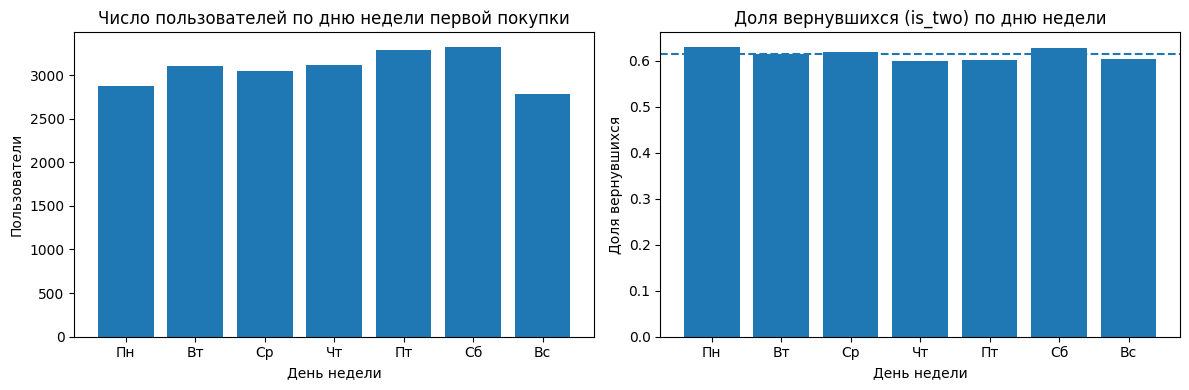

Базовая доля возврата по выборке: 61.36%


In [27]:
# 1) День недели первой покупки (0=Пн ... 6=Вс)
weekday_order = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
base['first_order_dow_num'] = base['first_order_ts'].dt.dayofweek
base['first_order_dow'] = base['first_order_dow_num'].map({
    0:'Пн', 1:'Вт', 2:'Ср', 3:'Чт', 4:'Пт', 5:'Сб', 6:'Вс'
})
# сделаем упорядоченную категорию, чтобы графики шли по дням
base['first_order_dow'] = pd.Categorical(base['first_order_dow'], categories=weekday_order, ordered=True)

# 2) Агрегация: количество пользователей и доля вернувшихся
dow_stats = (
    base
    .groupby('first_order_dow', observed=True)
    .agg(
        users=('user_id', 'nunique'),
        repeaters=('is_two', 'sum')
    )
    .reset_index()
    .sort_values('first_order_dow')
)
dow_stats['return_rate'] = dow_stats['repeaters'] / dow_stats['users']
dow_stats['share'] = dow_stats['users'] / base['user_id'].nunique()

display(dow_stats)

# 3) Визуализация: 
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Количество пользователей
axes[0].bar(dow_stats['first_order_dow'].astype(str), dow_stats['users'])
axes[0].set_title('Число пользователей по дню недели первой покупки')
axes[0].set_xlabel('День недели'); axes[0].set_ylabel('Пользователи')

# Доля вернувшихся
axes[1].bar(dow_stats['first_order_dow'].astype(str), dow_stats['return_rate'])
axes[1].axhline(overall_return, linestyle='--')  # средняя по выборке
axes[1].set_title('Доля вернувшихся (is_two) по дню недели')
axes[1].set_xlabel('День недели'); axes[1].set_ylabel('Доля вернувшихся')

plt.tight_layout()
plt.show()

print(f"Базовая доля возврата по выборке: {overall_return:.2%}")


Наблюдаем, что количество пользователей совершивших первую покупку в субботу наибольшее, далее пятница и четверг. 

Что видно по долям возврата (средняя по выборке — 61.36%):

Выше среднего: Пн 63.0%, Сб 62.7%, Ср 62.0%, Вт 61.5%.

Ниже среднего: Чт 59.9%, Пт 60.1%, Вс 60.3%.

Диапазон значений — от 59.9% (Чт) до 63.0% (Пн). Разброс умеренный, а доли пользователей по дням довольно схожи (≈13–15%), поэтому различия не выглядят случайными, но и эффект небольшой.

Вывод: день недели первой покупки слегка влияет на возврат — лучше всего выглядят понедельник/суббота. Для практики это скорее «тонкая настройка» коммуникаций, чем ключевой рычаг.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


Средний интервал (дни) 2–4: 21.46
Средний интервал (дни) 5+ : 9.95


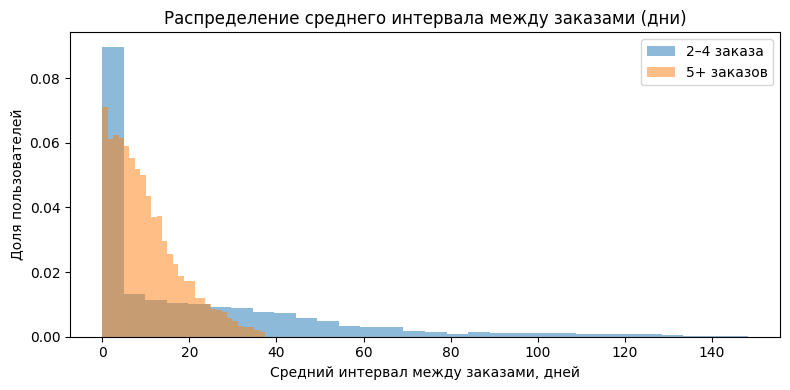

In [28]:
# Отбор групп 
grp_24 = base[(base["total_orders"] >= 2) & (base["total_orders"] <= 4)]["mean_days_between_orders"].dropna()
grp_5p = base[base["total_orders"] >= 5]["mean_days_between_orders"].dropna()

# Средние значения с округлением
print("Средний интервал (дни) 2–4:", round(np.mean(grp_24), 2))
print("Средний интервал (дни) 5+ :", round(np.mean(grp_5p), 2))

# Гистограммы распределения
plt.figure(figsize=(8, 4))
plt.hist(grp_24, bins=30, alpha=0.5, density=True, label="2–4 заказа")
plt.hist(grp_5p, bins=30, alpha=0.5, density=True, label="5+ заказов")
plt.title("Распределение среднего интервала между заказами (дни)")
plt.xlabel("Средний интервал между заказами, дней")
plt.ylabel("Доля пользователей")
plt.legend()
plt.tight_layout()
plt.show()

Вывод

У пользователей совершивших 2–4 заказа средний интервал между покупками составляет в среднем 21,46 дня. У пользователей с 5 и более заказами
средний интервал 9,95 дня.

Пользователи, которые совершают больше заказов (5 +), делают это чаще — интервалы между их покупками короче. Это говорит о том, что чем меньше среднее время между заказами, тем выше удержание клиента.
Иными словами, частота покупок прямо связана с лояльностью и вовлечённостью: чем активнее пользователь взаимодействует с сервисом, тем выше вероятность, что он вернётся снова.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

total_orders                1.000000
avg_tickets_per_order       0.541006
mean_days_between_orders    0.494849
first_region                0.296961
avg_revenue_per_order       0.206780
first_device                0.066292
first_event_type            0.000000
Name: total_orders, dtype: float64

<Figure size 640x480 with 0 Axes>

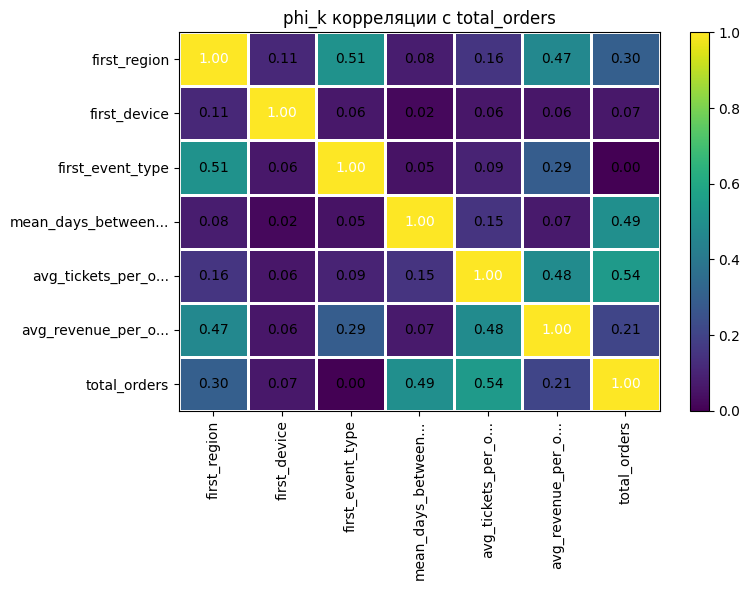

In [29]:
corr_df = base[[
    "total_orders","avg_revenue_per_order","avg_tickets_per_order","mean_days_between_orders",
    "first_event_type","first_device","first_region"
]].copy()

phik_mat = corr_df.phik_matrix(interval_cols=["avg_revenue_per_order","avg_tickets_per_order","mean_days_between_orders"])
display(phik_mat["total_orders"].sort_values(ascending=False))

plt.figure()
ax = plot_correlation_matrix(
    phik_mat.values,
    x_labels=phik_mat.columns,
    y_labels=phik_mat.index,
    vmin=0, vmax=1, color_map=None, figsize=(8,6)
)
plt.title("phi_k корреляции с total_orders")
plt.tight_layout(); plt.show()


Вывод:Наибольшее влияние на количество заказов оказывают среднее число билетов в заказе(0.541006) и интервал между покупками (0.494849) — пользователи, покупающие больше билетов и совершающие заказы чаще, демонстрируют более высокую вовлечённость. Эти метрики отражают активность и лояльность аудитории: чем короче паузы между покупками и крупнее заказы, тем выше частота обращений к сервису.
Регион и средний чек влияют умеренно, а устройство и тип первого события практически не связаны с количеством заказов.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

## Общий вывод и рекомендации:

В анализе использованы данные о заказах пользователей Яндекс.Афиши.
Данные были очищены: выручка приведена к рублям, удалены выбросы по 99-му перцентилю, типы данных оптимизированы. В итоговой выборке — ≈21,7 тыс. пользователей.

Основные результаты:

62% пользователей совершают повторные заказы, 29% — 5 и более заказов.

Средняя выручка с заказа — ≈575 ₽, среднее число билетов — 2,7.

Возвраты выше у пользователей, впервые купивших билеты в театр, с desktop-устройств, и в крупных регионах(Североярская обл.,Широковская обл.,Каменевский регион).

Пользователи с заказом 2–3 билета чаще возвращаются; при заказе 5+ билетов вероятность возврата резко падает.

Более короткие интервалы между покупками связаны с большей лояльностью.

День недели первой покупки влияет слабо (чуть выше возврат в пн/сб).

Корреляции: с количеством заказов сильнее всего связаны среднее число билетов (φₖ≈0.54) и интервал между заказами (φₖ≈0.49).

Рекомендации:

Основное внимание направить на ключевой сегмент — пользователей с 2–3 билетами в заказе и короткими интервалами между заказами.В рамках CRM-кампаний напоминать пользователям о повторной покупке через 7–10 дней после последнего заказа, когда вероятность возврата максимальна. Улучшить мобильный пользовательский опыт и развивать программы лояльности, стимулирующие повторные заказы. Фокусировать маркетинг на отстающих регионах. Не фокусироваться на типе первого события и типе устройства — их влияние на количество заказов минимально.


### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**

https://github.com/KseniiaKulinich/Ksu 
